In [113]:
import pandas as pd
from pytorch_tcn import TCN
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

model = TCN(
    num_inputs = 2,
    num_channels=[16, 32],
    kernel_size = 3,
    # dilation_reset: Optional[ int ] = None,
    dropout = 0.1,
    causal = True,
    use_norm = 'weight_norm',
    activation = 'relu',
    kernel_initializer = 'xavier_uniform',
    use_skip_connections = False,
    # input_shape: str = 'NCL',
    # embedding_shapes: Optional[ ArrayLike ] = None,
    # embedding_mode: str = 'add',
    # use_gate: bool = False,
    output_projection = 1,
    output_activation = 'gelu',
)
df = pd.read_csv("dataset.csv")


In [114]:

pd.options.display.max_rows = 999
count_by_sec_and_mrc = df.groupby(["sector", "mrc"]).count().unstack().tavg.T.reset_index()

for i, row in count_by_sec_and_mrc.iterrows():
    mrc = row["mrc"]
    row = row.drop("mrc")
    if (row == 96).all():
        pass
    else:
        print(mrc)
        print((row == 96))


def remove_incomplete_mrc_sectors(df):
    unwanted_mrc_sectors = [
        ("Administration régionale Kativik", "AGRICOLE"),
        ("Administration régionale Kativik", "INDUSTRIEL"),
        ("Caniapiscau", "AGRICOLE"),
        ("Le Golfe-du-Saint-Laurent", "AGRICOLE")
    ]

    for mrc, sector in unwanted_mrc_sectors:
        df = df[~((df["mrc"] == mrc) & (df["sector"] == sector))]


    return df

df = remove_incomplete_mrc_sectors(df)
df["sector_mrc"] = df["sector"] + df["mrc"]
sector_mrcs = df["sector_mrc"].unique()


Administration régionale Kativik
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL        False
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 3, dtype: bool
Caniapiscau
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL         True
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 15, dtype: bool
Le Golfe-du-Saint-Laurent
sector
AGRICOLE          False
COMMERCIAL         True
INDUSTRIEL         True
INSTITUTIONNEL     True
RÉSIDENTIEL        True
Name: 45, dtype: bool


In [115]:


def preprocess(df):
    new_df = pd.DataFrame()
    for sector_mrc in sector_mrcs:
        sector_mrc_df = df[df["sector_mrc"] == sector_mrc].sort_index()
        sector_mrc_df["total_kwh"] = sector_mrc_df["total_kwh"].interpolate(method="index")

        new_df = pd.concat([new_df, sector_mrc_df])

    return new_df
df = preprocess(df)

df = df.set_index(pd.to_datetime(df.date, format="%Y-%m-%d")).sort_index()

kwh_scaler = StandardScaler()
temp_scaler = StandardScaler()
df[['total_kwh']] = kwh_scaler.fit_transform(df[['total_kwh']])
df[['tavg']] = temp_scaler.fit_transform(df[['tavg']])

train_df = df["2016":"2022"]
test_df = df["2023":]
df = df.drop(columns=["date"])
df = df.sort_values(["mrc", "sector", "date"])


# df = torch.tensor(df).float()


In [ ]:
def get_sequence(df: pd.DataFrame, sector_mrc: str):
    """Get a sequence of total_kwh and tavg for a given sector_mrc"""

    # print(mrc)
    sequence = df[df.sector_mrc == sector_mrc]
    sequence = sequence[["total_kwh", "tavg"]]

    sequence["total_kwh"] = sequence["total_kwh"].diff()

    # Label is the next total_kwh
    sequence["label"] = sequence.total_kwh.shift(-1)
    # Drop the last row
    sequence = sequence.dropna()

    sequence = torch.tensor(sequence.values).float()

    # print(sequence.shape)

    return sequence

def get_n_sequences(sector_mrc: list[str], train=True):
    """Get a tensor of sequences for a list of sector_mrcs"""
    if train:
        df = train_df
    else:
        df = test_df

    stacked = torch.stack([get_sequence(df, sector_mrc) for sector_mrc in sector_mrc])
    return stacked


# def get_windowed_sequence(sequence, window_size=10):
#     '''
#     Args:
#         - Sequence: first dimension is the batch size, second dimension is the sequence length, third dimension is the number of features
#     Returns:
#         - Windowed sequence: first dimension is the batch size, second dimension is the sequence length, third dimension is the number of features * window_size
#     '''
#     batch_size, sequence_length, num_features = sequence.shape
#     windowed_sequence = torch.zeros((batch_size, sequence_length, num_features * (1 + window_size)))
#     windowed_sequence[:, :, :num_features] = sequence
#     for i in range(1, window_size + 1):
#         windowed_sequence[:, i:, num_features * i:num_features * (i + 1)] = sequence[:, :-i, :]

#     # Drop rows for which the window is incomplete
#     windowed_sequence = windowed_sequence[:, window_size:, :]

#     # print(windowed_sequence.shape)

#     return windowed_sequence


In [ ]:
EPOCHS = 20
BATCH_SIZE = 32



optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
losses = []
for epoch in range(EPOCHS):
    for i in range(0, len(sector_mrcs), BATCH_SIZE):
        sector_mrc = sector_mrcs[i:i + BATCH_SIZE]

        batch = get_n_sequences(sector_mrc)

        batch = batch.permute(0, 2, 1)
        X = batch[:, :-1, :]
        y = batch[:, -1, :]

        optim.zero_grad()
        output = model(X)
        loss = criterion(output.squeeze(), y)
        loss.backward()
        optim.step()
        print(f"Epoch {epoch} Batch {i} Loss {loss.item()}")


        losses.append(loss.item())
    print(f"Epoch {epoch} Loss {pd.Series(losses).mean()}")
    losses = []

Epoch 0 Batch 0 Loss 0.03114386275410652
Epoch 0 Batch 32 Loss 0.007367479149252176
Epoch 0 Batch 64 Loss 0.011145563796162605
Epoch 0 Batch 96 Loss 0.029115157201886177
Epoch 0 Batch 128 Loss 0.02094314619898796
Epoch 0 Batch 160 Loss 0.009190212935209274
Epoch 0 Batch 192 Loss 0.02602715604007244
Epoch 0 Batch 224 Loss 0.0055563258938491344
Epoch 0 Batch 256 Loss 0.0017634289106354117
Epoch 0 Batch 288 Loss 0.01931009441614151
Epoch 0 Batch 320 Loss 0.002727977465838194
Epoch 0 Batch 352 Loss 0.00347773521207273
Epoch 0 Batch 384 Loss 0.011359380558133125
Epoch 0 Batch 416 Loss 0.004407226573675871
Epoch 0 Loss 0.013109624793287367
Epoch 1 Batch 0 Loss 0.019308337941765785
Epoch 1 Batch 32 Loss 0.0032738137524574995
Epoch 1 Batch 64 Loss 0.007417145185172558
Epoch 1 Batch 96 Loss 0.02556183561682701
Epoch 1 Batch 128 Loss 0.01902586594223976
Epoch 1 Batch 160 Loss 0.008206024765968323
Epoch 1 Batch 192 Loss 0.02577481046319008
Epoch 1 Batch 224 Loss 0.005247781984508038
Epoch 1 Batch

In [118]:
# Test 
with torch.no_grad():
    sector_mrc = "COMMERCIALBeauce-Sartigan"
    batch = get_n_sequences([sector_mrc])
    batch = batch.permute(0, 2, 1)
    X = batch[:, :-1, :]
    y = batch[:, -1, :]
    output = model(X)
    print(output.squeeze())

tensor([-0.0181, -0.0320, -0.0460, -0.0198, -0.0052,  0.0027, -0.0094,  0.0227,
         0.0214,  0.0392,  0.0214, -0.0186, -0.0101, -0.0471, -0.0704, -0.0203,
         0.0003,  0.0070,  0.0040,  0.0012,  0.0374,  0.0474,  0.0086, -0.0105,
        -0.0196, -0.0427, -0.0583, -0.0132,  0.0030, -0.0017, -0.0087,  0.0183,
         0.0056,  0.0316,  0.0169, -0.0409, -0.0264, -0.0443, -0.0464, -0.0242,
        -0.0010, -0.0018,  0.0024,  0.0229,  0.0493,  0.0369,  0.0145, -0.0099,
        -0.0296, -0.0691, -0.0782, -0.0152, -0.0052, -0.0121, -0.0071,  0.0335,
         0.0089,  0.0576,  0.0211, -0.0025, -0.0114, -0.0397, -0.0216, -0.0079,
         0.0041,  0.0015, -0.0049,  0.0146,  0.0592,  0.0475,  0.0341, -0.0321,
        -0.0189, -0.0149, -0.0283, -0.0154, -0.0007, -0.0149, -0.0099,  0.0271,
         0.0132,  0.0713])


In [119]:
y = kwh_scaler.inverse_transform(y)
output = kwh_scaler.inverse_transform(output.squeeze(1))

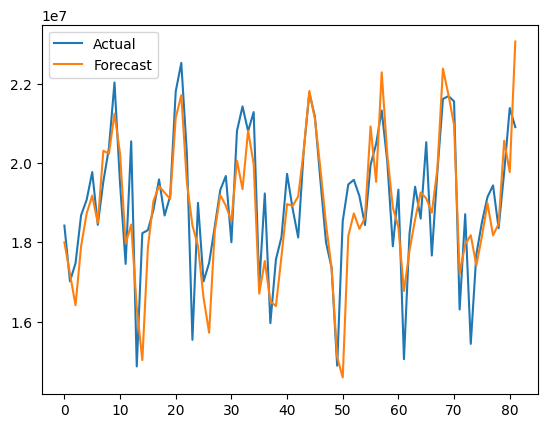

In [120]:
# Plot forecast vs actual
import matplotlib.pyplot as plt
plt.plot(y.squeeze())
plt.plot(output.squeeze())
plt.legend(["Actual", "Forecast"])
plt.show()

In [121]:
def validate():
    mapes = []
    with torch.no_grad():
        for sector_mrc in sector_mrcs:
            batch = get_n_sequences([sector_mrc], train=False)
            batch = batch.permute(0, 2, 1)
            X = batch[:, :-1, :]
            y = batch[:, -1, :]
            output = model(X)
            y = kwh_scaler.inverse_transform(y)
            output = kwh_scaler.inverse_transform(output.squeeze(1))
            # plt.plot(y.squeeze())
            # plt.plot(output.squeeze())
            # plt.legend(["Actual", "Forecast"])
            # plt.show()
            mape = (abs(y - output) / abs(y)).mean()
            print(f"MAPE for {sector_mrc} is {mape}")
            mapes.append(mape)

    return mapes

mapes = validate()

MAPE for AGRICOLEAbitibi is 0.028457730602739595
MAPE for INDUSTRIELMatawinie is 0.044503697112665004
MAPE for COMMERCIALMatawinie is 0.05718382823283039
MAPE for AGRICOLEMatawinie is 0.04025232710374487
MAPE for RÉSIDENTIELLes Moulins is 1.5395707852888134
MAPE for INSTITUTIONNELLes Moulins is 0.042268215586794715
MAPE for INDUSTRIELLes Moulins is 0.03902863856676868
MAPE for COMMERCIALLes Moulins is 0.11333411619096068
MAPE for AGRICOLELes Moulins is 0.03832851683184746
MAPE for RÉSIDENTIELL'Assomption is 1.096457227039435
MAPE for INSTITUTIONNELL'Assomption is 0.020962984184969582
MAPE for INDUSTRIELL'Assomption is 0.039699540077842446
MAPE for COMMERCIALL'Assomption is 0.0471055264414741
MAPE for AGRICOLEL'Assomption is 0.03640614379195373
MAPE for RÉSIDENTIELJoliette is 0.37454889395360963
MAPE for INSTITUTIONNELJoliette is 0.15619498718422697
MAPE for INDUSTRIELJoliette is 0.12454540402751244
MAPE for COMMERCIALJoliette is 0.027467391543009007
MAPE for AGRICOLEJoliette is 0.03686

In [122]:
import numpy as np
np.mean(mapes)

np.float64(0.2688944419543672)